# <h1 align= 'center'>Base Models</h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from scipy.stats import uniform
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# for importing data to colab
from google.colab import drive 
drive.mount('/content/drive')

# read from local dataset
# movies = pd.read_csv('data/imdb_data.csv')
# movies.sample(7)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## <h2> <center>Load preprocessed data</center></h2>

In [3]:
movies = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cleaned_data.csv')
movies.sample(7)

,Unnamed: 0,review,sentiment
16997,16997,ever came stori sick person rent slumber parti...,1
28670,28670,shemp find stand inherit million dollar marri ...,0
12936,12936,pleas think rent think watch coupl download cl...,0
3821,3821,martin lawrenc funni man runteldat much mind m...,0
44186,44186,total dreck love val kilmer surpris earlier ye...,0
3182,3182,girlfriend stun bad 15 minut call quit except ...,0
22136,22136,korin establish talent impress imag maker pro...,0


## <h2> <center>Text feature extraction</center></h2>

In [4]:
# todo: normalize if overfit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif


top_k = 10000

tfidf = TfidfVectorizer(
                    ngram_range = (1,2),
                    dtype = 'int32',
                    decode_error = 'replace',
                    analyzer = 'word',
                    min_df = 2,
                    norm = 'l2'
                    )
tfidf_reviews = tfidf.fit_transform(movies['review'])

# Select best 10,000(k) features, with feature importance measured by f_classif
selector = SelectKBest(f_classif, k = min(top_k, tfidf_reviews.shape[1]))
selector.fit(tfidf_reviews, movies['sentiment'])
vect_reviews = selector.transform(tfidf_reviews).astype('float32')

vect_reviews.shape

(50000, 10000)

## <h2> <center>Split the data</center></h2>

In [5]:
X = vect_reviews.toarray()
y = (np.array(movies['sentiment']))

# Here we split data to training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
print(f"Train dataset shape: {X_train.shape}, \nTest dataset shape: {X_test.shape}")

Train dataset shape: (40000, 10000), 
Test dataset shape: (10000, 10000)


In [0]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                           normalized=True, title='Confusion matrix'):
     matrix = confusion_matrix(y_true,y_pred)
     if normalized:
         matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
     annot_kws = {'fontsize':25, 
                  'fontstyle': 'italic'}
     sns.heatmap(matrix, vmax=vmax, annot=True,  annot_kws = annot_kws,
                 square=True, ax=ax, cbar=False,
                 cmap=sns.diverging_palette(20, 250, as_cmap=True), 
                  linecolor='black', linewidths=0.5,
                  xticklabels=class_names)
     ax.set_title(title, y=1.20, fontsize=16)
     ax.set_ylabel('True labels', fontsize=12)
     ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
     ax.set_yticklabels(class_names, rotation=0)

## <h2> <center>Modeling the data</center></h2>

### <h2> <center>Base Logistic Regression model</center></h2>

In [7]:
lr=LogisticRegression(max_iter=500 ,random_state=7, 
                      C = 10, penalty = 'l2') # found from Random Search 
lr.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
pred = lr.predict(X_test)
pred_train = lr.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  93.04249999999999
Test set Accuracy:  90.75999999999999


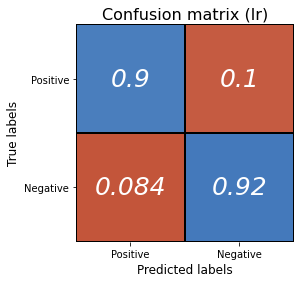

In [9]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (lr)',
                       class_names=['Positive', 'Negative'])

In [0]:
penalty = ['l2']
# Create regularization hyperparameter distribution using uniform distribution
C = [0.3, 1, 10, 30]
logistic = LogisticRegression()
# Create hyperparameter options
hyperparameters = dict(C=C,penalty=penalty)
pprint(hyperparameters)
lr_best = GridSearchCV(logistic, hyperparameters, scoring = 'accuracy', n_jobs =2,
                       cv = 2, verbose = 1, refit=True, return_train_score = True)

{'C': [0.3, 1, 3, 9, 10], 'penalty': ['l2']}


In [0]:
lr_best.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.3min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.3, 1, 3, 9, 10], 'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [0]:
lr_best_penalty = lr_best.best_estimator_.get_params()['penalty']
lr_best_c = lr_best.best_estimator_.get_params()['C']
print(f'Best Penalty: {lr_best_penalty}')
print(f'Best C: {lr_best_c}')

lr_best.best_params_

Best Penalty: l2
Best C: 10


{'C': 10, 'penalty': 'l2'}

In [0]:
pred = lr_best.predict(X_test)
pred_train = lr_best.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

print("Confusion Matrix:")
pd.DataFrame(confusion_matrix(pred, y_test))

Training set Accuracy:  93.045
Test set Accuracy:  90.73
Confusion Matrix:


,0,1
0,4480,422
1,505,4593


### <h2> <center>SVM Classifier</center></h2>

In [10]:
svm = SGDClassifier(random_state = 7, penalty = 'l2', loss = 'hinge')

svm.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=7, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
pred = svm.predict(X_test)
pred_train = svm.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  89.595
Test set Accuracy:  88.96


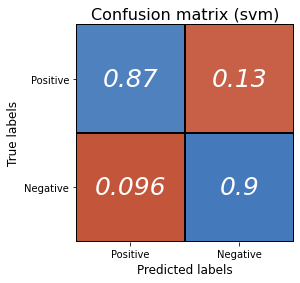

In [12]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (svm)',
                       class_names=['Positive', 'Negative'])

### <h2> <center>Multinomial Bayes Classifier</center></h2>

In [13]:
#training the model
mnb = MultinomialNB(alpha = 0.001) # best alpha found from Grid Search
#fitting the svm for bag of words
mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

In [14]:
pred = mnb.predict(X_test)
pred_train = mnb.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  91.1225
Test set Accuracy:  90.48


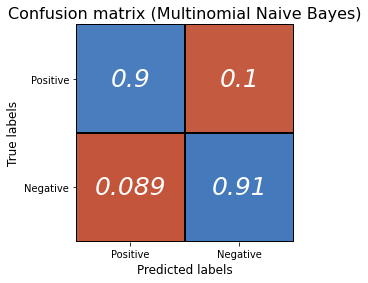

In [15]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (Multinomial Naive Bayes)',
                       class_names=['Positive', 'Negative'])

In [0]:
alpha =  [100, 10, 1, 0.1, 0.001, 0.0001, 0.00001]
hyperparam = dict(alpha = alpha)
mnb_best = GridSearchCV(mnb, hyperparam, scoring = 'accuracy', cv = 3, refit = True, verbose = 1, return_train_score = True)
pprint(hyperparam)

{'alpha': [100, 10, 1, 0.1, 0.001, 0.0001, 1e-05]}


In [0]:
mnb_best.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  1.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=MultinomialNB(alpha=0.001, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [100, 10, 1, 0.1, 0.001, 0.0001, 1e-05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [0]:
mnb_best_alpha = mnb_best.best_estimator_.get_params()['alpha']
print(f'Best alpha: {mnb_best_alpha}')
mnb_best.best_params_

Best alpha: 0.001


{'alpha': 0.001}

In [0]:
pred = mnb_best.predict(X_test)
pred_train = mnb_best.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

print("Confusion Matrix:")
pd.DataFrame(confusion_matrix(pred, y_test))

Training set Accuracy:  91.1225
Test set Accuracy:  90.48
Confusion Matrix:


,0,1
0,4478,445
1,507,4570


### <h2> <center>Random Forest Classifier</center></h2>

In [16]:
# takes a lot of time ...
rf = RandomForestClassifier(max_depth = 100, 
                            n_estimators = 500,
                            min_samples_leaf = 5,
                            min_samples_split = 2,
                            max_features = 'sqrt',
                            random_state = 7)  # found from Random Search

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [17]:
pred = rf.predict(X_test)
pred_train = rf.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  95.2325
Test set Accuracy:  85.87


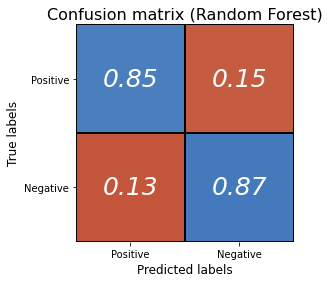

In [18]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (Random Forest)',
                       class_names=['Positive', 'Negative'])

In [0]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 3)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 3)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

hyperparam = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
pprint(hyperparam)
rf_temp = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf_temp, hyperparam, cv = 2, n_iter = 10, verbose = 1,
                        refit = False, return_train_score = True)

{'max_depth': [10, 55, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 550, 1000]}


In [0]:
# takes a lot of time ...
# rf_random.fit(X_train, y_train)

In [0]:
# pprint(rf_random.best_params_)

* The best models were Multinomial Naive Bayes and Logistic regression.
* Random forest seems to be overfitting.